In [1]:
import os
import time
from salpytools import salpylib 
import subprocess
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as py
import logging
import csv
import datetime
import numpy as np

%matplotlib inline

os.environ['LSST_DDS_DOMAIN'] = 'auxtelpath'

In [2]:
if False:
    logging.getLogger().setLevel(logging.DEBUG)
    logging.basicConfig(level=logging.DEBUG,
                    format='[%(asctime)s] [%(name)-12s:%(lineno)-4d] [%(levelname)-8s]: %(message)s',
                    datefmt='%m-%d %H:%M:%S')

In [3]:
def get_path_from_url(url):
    filename_no_path = url.split(':8000/')[1]
    wget_to = os.path.expanduser('~/data/')
    filename = os.path.join(wget_to, filename_no_path.split('/')[-1])
    return wget_to, filename
    
def grab_data_from_lfo_string(url):
    ## REMOVE UPON IMPLEMENTATION OF HARINI FIX TO sedSpectrograph
    if '/home/harini/TCS/SEDSpectrum/' in url:
        new_url=url.replace('/home/harini/TCS/SEDSpectrum/','')
        print('Grabbing modified url {}'.format(new_url))
        wget_to,filename = get_path_from_url(new_url)
    else:
        wget_to,filename = get_path_from_url(url)
    
    
    #wget_to = os.path.expanduser('/home/saluser/tmp/')
    if not os.path.exists(wget_to):
        os.makedirs(wget_to)
    if '/home/harini/TCS/SEDSpectrum/' in url:
        cmd = 'wget -P {} {}'.format(wget_to, new_url)
    else:
        cmd = 'wget -P {} {}'.format(wget_to, url)
    
    print(cmd)
    proc = subprocess.run(cmd, shell=True, check=True)
    
    if proc.returncode == 0:
        return (filename)
    else:
        raise IOError('Could not download data from url: {}'.format(url))

def wait_for_data(fname, largeFileObject):
    print('Wait_for_data: {}'.format(fname))
    lfo = None
    if fname is None:
        for i in range(10):
            if len(largeFileObject.largeFileObjectAvailable.url) > 0:
                lfo=grab_data_from_lfo_string(largeFileObject.largeFileObjectAvailable.url)
                print('Got %s' % lfo)
                return lfo
            else:
                print('Waiting for file...')
                time.sleep(0.5)
    else: # I DON'T UNDERSTAND WHEN THIS GETS CALLED - but it'll fail!
        for i in range(10):
            filename = get_path_from_url(str(largeFileObject.largeFileObjectAvailable.url))[-1]
            if fname != filename:
                lfo=grab_data_from_scp_string(largeFileObject.largeFileObjectAvailable.url)
                print('Got %s' % lfo)
                return lfo
            else:
                print('Waiting for file...')
                time.sleep(0.5)

    return None
    

In [4]:
def getFileName():
    tmp_file='/tmp/atcamera_filename_current.dat'
    # This function assumes the file created in tmp_file
    # was written by this function. No error handling exists should the file be
    # modified or created via another method.
    import os
    import datetime
    import logging
    
    def timeStamped(fname_suffix, fmt='AT-O-%Y%m%d-{fname:05}'):
        return (datetime.datetime.now().strftime(fmt).format(fname=fname_suffix))
    
    # today's format
    number=0 # assume zero for the moment
    file_date = timeStamped(number).split('-')[2]
    
    # Check to see if a file exists with a past filename
    if os.path.exists(tmp_file):
        # read in the file
        fh = open(tmp_file, 'r')
        first_line = (fh.readline())
        logging.info('Previous line in existing file {}'.format(first_line))
        
        # check to see if the date is the same
        logging.debug('file_date is: {}'.format(file_date))
        logging.debug('first_line is: {}'.format(first_line))
        if file_date in first_line:
            # grab file number and augment it
            old_num = first_line.split(',')[1]
            logging.debug('Previous Image number was: {}'.format(old_num))
            number = 1+int(old_num)
            logging.info('Incrementing from file to: {}'.format(number))
            fh.close()
        
        # Delete the file
        os.remove(tmp_file)

    # write a file with the new data
    fh = open(tmp_file, 'w')
    lines_of_text = [str(file_date)+','+str(number)]
    fh.writelines(lines_of_text)
    fh.close()
    
    fname = timeStamped(number)
    print('Newly generated filename: {}'.format(fname))
    return(fname)
    

In [5]:
#getFileName()

In [6]:
component_list = [('atMonochromator', None) , ('atcamera',None)]

In [7]:
print('Subscribing to events from the two components...')
atMonochromator = salpylib.DDSSubscriberContainer('atMonochromator',
                                                  device_id=None)
atcamera = salpylib.DDSSubscriberContainer('atcamera',
                                                  device_id=None)
print('DONE')

Subscribing to events from the two components...
DONE


In [8]:
# Check devices are alive - these should all be 1 !
print(atMonochromator.heartbeat.heartbeat)
# print(atcamera.heartbeat.heartbeat) - camera has no heartbeat, how do we know if it's alive?

1


In [9]:
# want to create a class that captures all of the different components
# Need to declare its existance here
class SenderContainer():
    pass

In [10]:
sender = SenderContainer()
for component in component_list:
    setattr(sender, component[0], salpylib.DDSSend(component[0], component[1]))
    getattr(getattr(sender, component[0]),'start')()

## Bring components to the correct state

In [11]:
cmd_id1 = sender.atMonochromator.send_Command('enable', wait_command=False)

resp, ack = sender.atMonochromator.waitForCompletion(cmd_id1[0])
print(resp, ack)

596516649 (-300, 0, 'Command executed in the wrong state')


In [12]:
cmd_id2 = sender.atcamera.send_Command('enable',
                              wait_command=False)

resp, ack = sender.atcamera.waitForCompletion(cmd_id2[0])
print(resp, ack)


1189641421 (-302, 0, 'Ack : NO Command not accepted in State{LSE209State = ENABLED}')


## Start Loop over wavelengths

In [278]:
wavelength_arr=np.array([700])
wavelength_max=np.zeros_like(wavelength_arr)

expTime = 8.0

plot = False
log = True
if plot:
    fig1 = py.figure(1, figsize=(10, 8))
    ax1 = fig1.add_subplot(212)
    ax2 = fig1.add_subplot(211)

if log:

    logfilename='/tmp/'+(datetime.datetime.now().strftime('%Y%m%d'))+'_focus_test_log.csv'
    if not os.path.exists(logfilename):
        with open(logfilename, mode='w', newline='') as log_file:
            log_writer = csv.writer(log_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            top_line = ['#atcamera.endReadout.imageName','atcamera.endReadout.exposureTime','atMonochromator.wavelength.wavelength',
                        'atMonochromator.selectedGrating.gratingType',
                        'atMonochromator entry slit',
                        'atMonochromator exit slit']
            log_writer.writerow(top_line)
    
for i,wave in enumerate(wavelength_arr):
    print('Setting up for wavelength {} [enumeration {}] :'.format(wave,i))
    
    sedSpectrometer_fname, electrometer_fname = [None, None]
    cmd_id = sender.atMonochromator.send_Command('updateMonochromatorSetup',gratingType=2,
                                             fontExitSlitWidth = 1.0, 
                                             fontEntranceSlitWidth = 1.0,
                                             wavelength = wave, wait_command=True)
    
   
    # wait a second before starting to capture
    #time.sleep(1)
    
    atcamera_fname = getFileName()
    cmd_id4 = sender.atcamera.send_Command('takeImages', numImages = 1, 
                                       expTime = expTime, shutter = True, 
                                       imageSequenceName = str(atcamera_fname),
                                       science = True,
                                       wait_command=False)
    
    resp, ack = sender.atcamera.waitForCompletion(cmd_id4[0])
    print(resp, ack)
       
    # Adding a sleep here to see if it results in fewer dropped images
    # wait a second before starting to capture
    #time.sleep(10)
    
    if resp == -1:
        raise IOError('atcamera timed out for wavelength {} [enumeration {}] :'.format(wave,i))
    if ack[0] != 303:
        raise IOError('atcamera did not complete successfully')
    
    # Create log of data since I'm afraid it'll all get lost in the EFD
    # or I'll never find it
    
    if log:
         with open(logfilename, mode='a', newline='') as log_file:
                log_writer = csv.writer(log_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                log_writer.writerow([atcamera.endReadout.imageName,atcamera.endReadout.exposureTime,atMonochromator.wavelength.wavelength,
                                     atMonochromator.selectedGrating.gratingType,
                                   atMonochromator.subscribers['slitWidth'].myDatalist[-2].slitPosition,
                                   atMonochromator.subscribers['slitWidth'].myDatalist[-1].slitPosition])
        
    if plot:
        print('plotting')

Setting up for wavelength 700 [enumeration 0] :
Newly generated filename: AT-O-20180926-00027
1350490054 (303, 0, 'Done : OK')


In [318]:
atMonochromator.selectedGrating.gratingType

1

In [88]:
import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter as gauss_filt

# Read in image
dir = '/mnt/dmcs/20180823'
dir = '/mnt/data/ats/mcm/'
atcamera_fname='AT-O-20180928-00015'
full_file_name=dir+atcamera_fname+'.fits'
print('Opening {}'.format(full_file_name))
hdu_list = fits.open(full_file_name)
#hdu_list.info()
im=hdu_list[12].data # for camera data

# Find star by convolution with gaussian, then grab the max
tmp=gauss_filt(im,[5,5],mode='constant',cval=0)
print(np.max(tmp))
value=None
ind=np.argmax(tmp)
ind2d = np.unravel_index(ind,tmp.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(50)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < 2047 else 2047
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < 512 else 512
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(tmp[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,tmp[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

Opening /mnt/data/ats/mcm/AT-O-20180928-00015.fits
11047
centroid at y,x: 1920 371
subimage being made from ymin,ymax,xmin,xmax:1870 1970 321 421
new centroid at y,x: 50 50


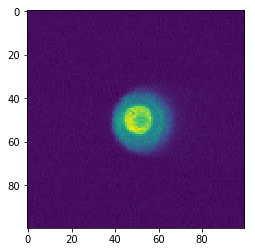

In [89]:
im_sub=im[ymin:ymax,xmin:xmax]
im_sub=im_sub-np.median(im_sub)
py.imshow(im_sub)
hdu_list.close()

50
50


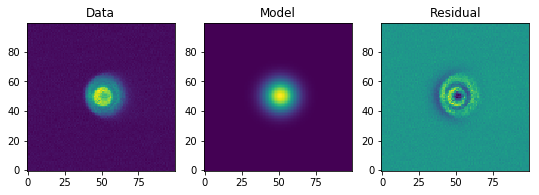

In [90]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
py.figure(figsize=(9, 5))
py.subplot(1, 3, 1)
py.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
py.title("Data")
py.subplot(1, 3, 2)
py.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
py.title("Model")
py.subplot(1, 3, 3)
py.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
py.title("Residual")

In [91]:
print(atcamera_fname)
print(p)

AT-O-20180928-00015
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
      amplitude      x_mean        y_mean       x_stddev      y_stddev   theta
    ------------- ------------ ------------- ------------- ------------- -----
    1209.92208167 51.082002477 50.3370484173 7.53175193769 7.23502747864   0.0


In [277]:
# file, focus pos [in], amplitude, x_mean, y_mean, x_stddev, y_stddev, theta [fixed] 

#AT-O-20180926-00007, 0.589, 2792.34040405, 76.3187427061, 70.6949776879, 10.5250738182, 11.5540604481,   0.0
#AT-O-20180926-00010.fits,0.584, 4652.81858626, 419.985088191, 36.1386853783, 8.8462953384, 9.81862666975,   0.0
#AT-O-20180926-00013,0.611,447.746063627 239.000072699 85.6124941322 26.3465997095 31.3922441199   0.0
#AT-O-20180926-00014, 0.560, 13755.5395601, 112.621980852, 75.8147418115, 5.66348802593, 5.16336089279,   0.0
#AT-O-20180926-00015, 0.541, 1344.39176121 103.884124588 57.6255140042 17.6003542084 17.3475235955   0.0
#AT-O-20180926-00021, 0.562, 15870.7070175, 98.2141308141, 56.3088127495, 5.15586715284, 4.88307143492,   0.0
#AT-O-20180926-00022, 0.571, 16223.3326982 67.9783654212 71.5033438187 4.7371224009 5.06486183693   0.0
#AT-O-20180926-00023, 0.586, 9275.43049545 34.7974048887 77.5859248738 5.83456358727 6.61970962653   0.0
#AT-O-20180926-00025, 0.575 ,12354.1164511, 31.4979221705, 19.0930890249, 5.24240919033, 5.64293081215,   0.0
#AT-O-20180926-00026, 0.568, 17254.2873684 108.042222433 40.4834054611 4.74433627636 4.72385908281   0.0
#AT-O-20180926-00027, 0.572, 15608.0749458 67.6837717553 94.7478189974 4.97175179996 4.99869109278   0.0

0.568

In [39]:
# expecting ~8 pixel image - but it'll be resolved... so not a top hat, but not a gaussian